<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Experiments/HybridTransformer2SVM_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel
import datasets

gptModel = 'raygx/GPT-NepSA-T2' ## Fine-tuned Model ## 'raygx/Nepali-GPT2-CausalLM' ## Pre-Trained LM ##
gptTokenizer = PreTrainedTokenizerFast.from_pretrained(gptModel,padding_side='left')
gptModel = TFAutoModel.from_pretrained(gptModel)

bertModel = 'raygx/BERT-NepSA-T2' ## Fine-tuned Model for SA ## 'raygx/BertClassifier4NepaliNews' ## Fine-tuned Model for NewsClassification ## 'Shushant/nepaliBERT' ## Pre-Trained LM ##
bertTokenizer = BertTokenizerFast.from_pretrained(bertModel)
try:
    bertModel = TFAutoModel.from_pretrained(bertModel)#,revision='3d8fa5f1a60104bad4592461a0237b85b9c8756c')
except:
    bertModel = TFAutoModel.from_pretrained(bertModel,from_pt=True)

gptModel.config, bertModel.config

Some layers from the model checkpoint at raygx/GPT-NepSA-T2 were not used when initializing TFGPT2Model: ['score']
- This IS expected if you are initializing TFGPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFGPT2Model were initialized from the model checkpoint at raygx/GPT-NepSA-T2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Some layers from the model checkpoint at raygx/BERT-NepSA-T2 were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at raygx/BERT-NepSA-T2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(GPT2Config {
   "_name_or_path": "raygx/GPT-NepSA-T2",
   "activation_function": "gelu_new",
   "architectures": [
     "GPT2ForSequenceClassification"
   ],
   "attn_pdrop": 0.1,
   "bos_token_id": 1,
   "embd_pdrop": 0.1,
   "eos_token_id": 2,
   "id2label": {
     "0": "NEUTRAL",
     "1": "POSITIVE",
     "2": "NEGATIVE"
   },
   "initializer_range": 0.02,
   "label2id": {
     "NEGATIVE": 2,
     "NEUTRAL": 0,
     "POSITIVE": 1
   },
   "layer_norm_epsilon": 1e-05,
   "model_type": "gpt2",
   "n_ctx": 1024,
   "n_embd": 768,
   "n_head": 12,
   "n_inner": null,
   "n_layer": 12,
   "n_positions": 1024,
   "pad_token_id": 3,
   "reorder_and_upcast_attn": false,
   "resid_pdrop": 0.1,
   "scale_attn_by_inverse_layer_idx": false,
   "scale_attn_weights": true,
   "summary_activation": null,
   "summary_first_dropout": 0.1,
   "summary_proj_to_labels": true,
   "summary_type": "cls_index",
   "summary_use_proj": true,
   "task_specific_params": {
     "text-generation": {
       "do

In [ ]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [ ]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [ ]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

#0:   0%|          | 0/8308 [00:00<?, ?ex/s]

#1:   0%|          | 0/8308 [00:00<?, ?ex/s]

#2:   0%|          | 0/8308 [00:00<?, ?ex/s]

#3:   0%|          | 0/8308 [00:00<?, ?ex/s]

#0:   0%|          | 0/2078 [00:00<?, ?ex/s]

#1:   0%|          | 0/2077 [00:00<?, ?ex/s]

#2:   0%|          | 0/2077 [00:00<?, ?ex/s]

#3:   0%|          | 0/2077 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [ ]:
import tensorflow as tf

class GPTEmbedding(tf.keras.layers.Layer):
    def __init__(self, model,tokenizer, max_token_len=128,padding='max_length', trailing_context=4,truncation=True):
        super().__init__()
        self.embedding = model
        self.tokenizer = tokenizer
        self.tokenizer.padding_side = 'left'
        self.max_token = max_token_len
        self.padding = padding
        self.truncation = truncation
        self.trailing_context = trailing_context
        self.trainable=False

    def call(self, x):
        embeddings = self.embedding(
                      self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
                    )[0][:,-self.trailing_context:,:]

        return tf.reduce_logsumexp(embeddings,axis=1)

class BERTEmbedding(tf.keras.layers.Layer):
    def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
        super().__init__()
        self.embedding = model
        self.tokenizer = tokenizer
        self.max_token = max_token_len
        self.padding = padding
        self.truncation = truncation
        self.trainable=False

    def call(self, x):
        return self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))[1]

### Preparing Training Data

In [ ]:
from tqdm.auto import tqdm

gptEmbd = GPTEmbedding(model=gptModel,tokenizer=gptTokenizer,trailing_context=1,max_token_len=100)
bertEmbd = BERTEmbedding(model=bertModel,tokenizer=bertTokenizer,max_token_len=100)

X = None
batch = 32
for i in tqdm(range(0,data['train'].num_rows,batch)):
    feat1 = bertEmbd(data['train'][i:i+batch]['text'])
    feat2 = gptEmbd(data['train'][i:i+batch]['text'])

    feat = tf.concat((feat1,feat2),1)
    if i==0:
        X = feat
    else:
        X = np.concatenate([X,feat],axis=0)

X.shape

  0%|          | 0/1039 [00:00<?, ?it/s]

(33232, 1536)

In [ ]:
### Attention Visualization
# import seaborn as sns

# output = bertModel(bertTokenizer(data['train'][:1]['text'],return_tensors='tf'),output_attentions=True)
# print(output.keys())
# print(output['attentions'][1].shape)

### output['attentions'][nLayer][nBatch][nHead]
# sns.heatmap(output['attentions'][-2][0][-6])

## Training

In [ ]:
%%time
from sklearn import svm

y = data['train']['label']
clf = svm.SVC()  ## default 'rbf'
clf.fit(X, y)
clf.classes_

CPU times: user 10min 4s, sys: 1.16 s, total: 10min 5s
Wall time: 10min 7s


array([0, 1, 2])

### Preparing Test Data

In [ ]:
testX = None
for i in tqdm(range(0,data['test'].num_rows,batch)):
    feat1 = bertEmbd(data['test'][i:i+batch]['text'])
    feat2 = gptEmbd(data['test'][i:i+batch]['text'])

    feat = tf.concat([feat1,feat2],1)
    if i==0:
        testX = feat
    else:
        testX = np.concatenate([testX,feat],axis=0)

testX.shape

  0%|          | 0/260 [00:00<?, ?it/s]

(8309, 1536)

## Evaluation

In [ ]:
%%time
predictions = clf.predict(testX)

CPU times: user 3min 4s, sys: 308 ms, total: 3min 4s
Wall time: 3min 5s


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y = data['test']['label']
print("F1-Score",f1_score(np.array(y),predictions,average='weighted'))
print("Precision-Score",precision_score(np.array(y),predictions,average='weighted'))
print("Recall-Score",recall_score(np.array(y),predictions,average='weighted'))
print("accuracy_Score",accuracy_score(np.array(y),predictions))

F1-Score 0.8540843291132019
Precision-Score 0.856399122779771
Recall-Score 0.8538933686364183
accuracy_Score 0.8538933686364183


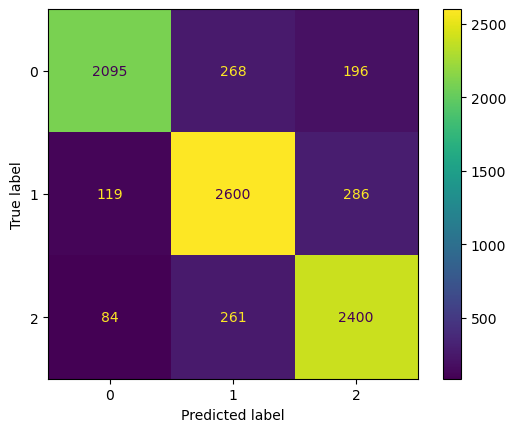

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(np.array(y),predictions,num_classes=3).numpy())
cmd.plot()